# info session 
docker voyant
url:[https://github.com/voyanttools/docker/wiki/Voyant-Docker-Tutorial]

shared server
url:[https://github.com/voyanttools/VoyantServer/wiki/Running-as-a-Shared-Server#starting-voyantserver-from-the-command-line]

voyant embed 
url:[https://voyant-tools.org/docs/tutorial-embedding.html]

# code session

In [1]:
# Import required libraries
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from wordcloud import WordCloud
import json
import urllib.parse
import webbrowser
from email.parser import Parser
import string
import matplotlib.pyplot as plt
import tempfile
import os
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download required NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# enron email dataset
file_path = '../data/inputs/enron/enron_subset.csv'

# Read the file
# if file_path.endswith('.csv'):
#     df = pd.read_csv(file_path)
#     text = ' '.join(df['message'].dropna().tolist())
# else:
#     with open(file_path, 'r', encoding='utf-8') as file:
#         text = file.read()

df = pd.read_csv(file_path)

In [4]:
df

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
995,allen-p/all_documents/458.,Message-ID: <20430828.1075855696096.JavaMail.e...
996,allen-p/all_documents/459.,Message-ID: <18425275.1075855696118.JavaMail.e...
997,allen-p/all_documents/46.,Message-ID: <24036204.1075855666506.JavaMail.e...
998,allen-p/all_documents/460.,Message-ID: <33307764.1075855696139.JavaMail.e...


## pre-processing

In [5]:
def extract(text):
    email = Parser().parsestr(text)
    
    return {
        "email_body": email.get_payload(),
        "sender": email["From"],
        "receiver": email["To"],
        "date": email["Date"],
        "subject": email["Subject"],
    }

In [6]:
email_data = df["message"].apply(extract)
df = df.join(pd.DataFrame(email_data.tolist()))

In [7]:
def nlp(text):
    """Clean and tokenize text"""
    # Remove HTML tags
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)

    # Split into words and sentences
    sen_tokens = sent_tokenize(text)
    wrd_tokens = word_tokenize(text.lower())

    # Remove stopwords & punctuation
    stopwords = set(nltk.corpus.stopwords.words('english'))
    filtered_wrds_token = [word for word in wrd_tokens if word.isalnum() and word not in stopwords and word not in string.punctuation]
    
    return filtered_wrds_token, sen_tokens, ' '.join(filtered_wrds_token)

In [8]:
def cleansing(text):
    """Clean and tokenize text"""
    # Remove HTML tags
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    wrd_tokens = word_tokenize(text.lower())

    # Remove stopwords & punctuation
    stopwords = set(nltk.corpus.stopwords.words('english'))
    filtered_wrds_token = [word for word in wrd_tokens if word.isalnum() and word not in stopwords and word not in string.punctuation]
    
    return ' '.join(filtered_wrds_token)

In [9]:
# analyse engine
configuration = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": 'en', "model_name": "en_core_web_sm"}],
}
provider = NlpEngineProvider(nlp_configuration=configuration)
nlp_engine = provider.create_engine()
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=['en'])

# mask engine
anonymizer = AnonymizerEngine()
operator_config = {
    "PERSON": OperatorConfig("replace", {"new_value": "<PERSON>"}),
    "LOCATION": OperatorConfig("replace", {"new_value": "<LOCATION>"}),
    "DATE_TIME": OperatorConfig("replace", {"new_value": "<DATE_TIME>"}),
    "ORGANIZATION": OperatorConfig("replace", {"new_value": "<ORGANIZATION>"}),
    "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE_NUMBER>"}),
    "EMAIL_ADDRESS": OperatorConfig("replace", {"new_value": "<EMAIL_ADDRESS>"}),
    "CREDIT_CARD": OperatorConfig("replace", {"new_value": "<CREDIT_CARD>"}),
}

def PII_detection_masking(text):
    # do the analyze and masking 
    chunk_size = 10000
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    masked_text = []
    for chunk in chunks:
        results = analyzer.analyze(text=chunk, language='en')
        masked_chunk = anonymizer.anonymize(text=chunk, analyzer_results=results,operators=operator_config)
        masked_text.append(masked_chunk.text)

    return ' '.join(masked_text)


In [10]:
# masking
df['masked_text'] = df['email_body'].apply(PII_detection_masking)

In [11]:
# cleasing 
df['clean_text'] = df['masked_text'].apply(cleansing)

In [12]:
# date cleasing
df['time'] = df['date'].str[:-12].apply(lambda x: datetime.strptime(x, '%a, %d %b %Y %H:%M:%S'))

In [13]:
df.head()

,file,message,email_body,sender,receiver,date,subject,masked_text,clean_text,time
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\r\n\r\n,phillip.allen@enron.com,tim.belden@enron.com,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Here is our forecast\r\n\r\n,forecast,2001-05-14 16:39:00
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,phillip.allen@enron.com,john.lavorato@enron.com,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,Traveling to have a business meeting takes the...,traveling business meeting takes fun trip espe...,2001-05-04 13:51:00
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,phillip.allen@enron.com,leah.arsdall@enron.com,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!,test successful way go,2000-10-18 03:00:00
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\r\n\r\n Can you send me a schedule of t...",phillip.allen@enron.com,randall.gay@enron.com,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",,"<PERSON>,\r\n\r\n Can you send me a schedule o...",send schedule salary level everyone scheduling...,2000-10-23 06:13:00
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,greg.piper@enron.com,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,Let's shoot for <DATE_TIME> at 11:45.,let shoot,2000-08-31 05:07:00


## local analysis

In [20]:
# convert to date and counts
date_counts = df['time'].dt.date.value_counts().sort_index()  


plt.figure(figsize=(12, 6))
plt.scatter(date_counts.index, date_counts.values, color='b', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Email Date Distribution')
plt.xticks(rotation=45) 
plt.savefig('../outputs/date_distribution')
plt.close()

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(date_counts.values, bins=50, kde=True, color="purple")

plt.xlabel("Emails Per Day")
plt.ylabel("Frequency")
plt.title("Distribution of Emails Per Day")
plt.savefig('../outputs/email_per_day_distribution')
plt.close()



In [40]:

# tokenizer and classifier download for sentiment analysis 
# model capable for English, Dutch, German, French, Italian, Spanish  
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
sentiment_classifier = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# 0 - very negative
# 1 - negative
# 2 - neutral
# 3 - positive
# 4 - very positive

In [38]:
### sentiment analysis over date time aggregation  

def sentiment_classication(df):
    date = df.get('time')
    raw_text = df.get('masked_text').tolist()
    clean_text = [re.sub(r'[\r\n]+', '', raw) for raw in raw_text]
    sentiment_df = pd.DataFrame({'date': date.tolist() , 'text' : clean_text})
    sentiment_Scores = []
    sentiment_labels = []

    
    for email_body in sentiment_df['text']:
        tokens = tokenizer(email_body, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            outputs = sentiment_classifier(**tokens)
        
        # dim = 1 -> regulate along the row (prob for each class) 
        score = outputs.logits.softmax(dim=1)
        # dim = 0 -> average the score for each class
        sentiment_score = score.mean(dim=0)
        sentiment_label = sentiment_score.argmax().item()
        
        sentiment_Scores.append(sentiment_score.tolist())
        sentiment_labels.append(sentiment_label)

    sentiment_df['sentiment_score'] = sentiment_Scores
    sentiment_df['sentiment_label'] = sentiment_labels
    
    return sentiment_df

In [24]:
sentiment_df = sentiment_classication(df)

In [25]:
# aggregate sentiment label by date
aggregate_df = sentiment_df.groupby('date')['sentiment_label'].value_counts().unstack().fillna(0).astype(int)
aggregate_df['total'] = aggregate_df.sum(axis=1)
aggregate_df['mean'] = aggregate_df.drop(columns='total').mean(axis=1)


aggregate_df

sentiment_label,0,1,2,3,4,total,mean
date,,,,,,,
1979-12-31 16:00:00,1,0,1,1,2,5,1.0
1999-12-10 07:00:00,0,0,0,2,0,2,0.4
1999-12-11 06:39:00,0,2,0,0,0,2,0.4
2000-01-04 11:39:00,0,0,0,1,0,1,0.2
2000-01-05 05:35:00,2,0,0,0,0,2,0.4
...,...,...,...,...,...,...,...
2001-05-14 09:39:00,1,0,0,0,0,1,0.2
2001-05-14 10:24:00,1,0,0,0,0,1,0.2
2001-05-14 10:32:00,1,0,0,0,0,1,0.2


In [26]:
# Assuming aggregate_df is your DataFrame containing the sentiment data
# skip first line for better visualization
plot_df = aggregate_df[1:]

c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **

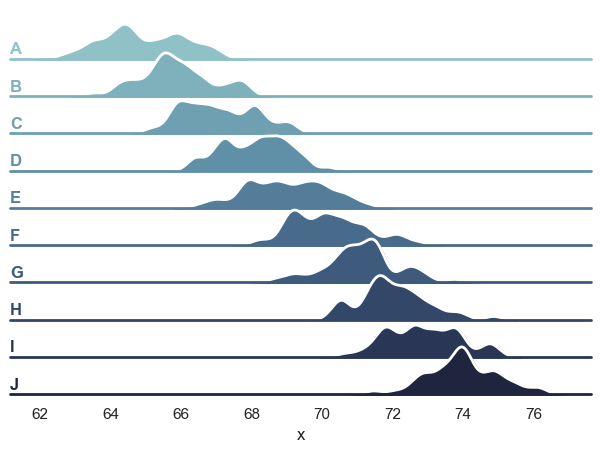

In [ ]:

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [ ]:
plot_df = plot_df.reset_index()
plot_df["date"] = pd.to_datetime(plot_df["date"])
   
df_long = plot_df.melt(id_vars="date", value_vars=[0, 1, 2, 3, 4], 
                        var_name="sentiment_label", value_name="count")

# filter out 0 rows since Kernel Density Estimation can not handle 0 values
df_long = df_long[df_long["count"] > 0]

c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Chris\anaconda3\envs\pontusX\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **

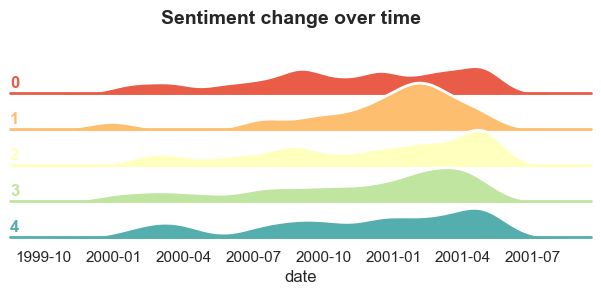

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette("Spectral", n_colors=5)
g = sns.FacetGrid(df_long, row="sentiment_label", hue="sentiment_label", 
                  aspect=15, height=.5, palette=pal)

# draw KDE plot - parameter : bandwidth, bw_adjust to determine the smoothness of the plot
g.map(sns.kdeplot, "date", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "date", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "date")

g.figure.subplots_adjust(hspace=-.25)
g.figure.suptitle("Sentiment change over time", fontsize=14, fontweight="bold", y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.savefig("sentiment_trend.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## official hosted voyant server

In [64]:
def send_to_official_voyant(text, return_url=False):
    """Send text to Voyant Tools and return/open the URL"""
    
    # Use the public Voyant Tools server with the correct endpoint
    base_url = "https://voyant-tools.org/"
    
    # Create form data
    data = {
        'inputFormat': 'text',
        'input': text
    }
    
    # Send POST request
    try:
        response = requests.post(base_url, data=data)
        if response.status_code == 200:
            # Extract the corpus ID from the response URL
            corpus_url = response.url
            
            if return_url:
                return corpus_url
            else:
                webbrowser.open(corpus_url)
                return "Opened in Voyant Tools"
        else:
            return f"Error: Server returned status code {response.status_code}"
    except Exception as e:
        return f"Error: {str(e)}"

In [65]:
all_email = ' '.join(df['clean_text'])

url = send_to_official_voyant(all_email,return_url=True)

In [66]:
url

'https://voyant-tools.org/?corpus=b38fa06c994f8a9b609f7dfa8761be63'

attampted but not working 

In [57]:
def send_to_voyant_large_text(text, return_url=False):
    """Create a Voyant Tools corpus and return/open the URL"""
    # Use the public Voyant Tools server
    base_url = "https://voyant-tools.org/upload"
    
    # Create a temporary file with the text
    with tempfile.NamedTemporaryFile(mode='w', suffix='.txt', delete=False) as f:
        f.write(text)
        temp_filename = f.name
    
    # Create multipart form data
    files = {
        'upload': (os.path.basename(temp_filename), open(temp_filename, 'rb'), 'text/plain')
    }
    
    # Upload the file
    response = requests.post(base_url, files=files)
    
    # Clean up temporary file
    os.unlink(temp_filename)
    
    # Get the corpus ID from the response
    if response.status_code == 200:
        corpus_url = f"https://voyant-tools.org/?corpus={response.text.strip()}"
        
        if return_url:
            return corpus_url
        else:
            webbrowser.open(corpus_url)
            return "Opened in Voyant Tools"
    else:
        return f"Error: {response.status_code}, {response.reason}"

## stand alone voyant server

In [30]:
def send_to_local_voyant(text, port = 8888, return_url=False):
    """Send text to Voyant Tools and return/open the URL"""
    
    # connect to local server 
    base_url = f"http://localhost:{port}"
    
    # Create form data
    data = {
        'inputFormat': 'text',
        'input': text
    }
    
    # Send POST request
    try:
        response = requests.post(base_url, data=data)
        if response.status_code == 200:
            # Extract the corpus ID from the response URL
            corpus_url = response.url
            
            if return_url:
                return corpus_url
            else:
                webbrowser.open(corpus_url)
                return "Opened in Voyant Tools"
        else:
            return f"Error: Server returned status code {response.status_code}"
    except Exception as e:
        return f"Error: {str(e)}"

In [31]:
all_email = ' '.join(df['clean_text'])
url = send_to_local_voyant(all_email,return_url=True)
url

'http://localhost:8888/?corpus=2333989e10d8d6420cd3953462d33dcf'

In [34]:
data = {
    'inputFormat': 'text',
    'input': all_email
}
res = requests.post('http://localhost:8888',data)

In [47]:
res.url

match = re.search(r'corpus=([a-f0-9]+)', res.url)
match.group(1)

'2333989e10d8d6420cd3953462d33dcf'

### Embed voyant into html page

In [ ]:
def generate_local_voyant_html(text, output_path='../outputs/voyant_analysis.html', port=8888):
    """Generate a standalone HTML page with Voyant visualizations using local Voyant server"""

    data = {
        'inputFormat': 'text',
        'input': text
    }
    
    # Send to local Voyant server
    base_url = f'http://localhost:{port}'
    response = requests.post(base_url, data=data)


    if response.status_code != 200:
        raise Exception(f"Failed to connect to Voyant: {response.status_code}")

    match = re.search(r'corpus=([a-f0-9]+)', url)
    corpus = match.group(1)
    
    cirrus_url = f'http://localhost:8888/tool/Cirrus/?corpus={corpus}'
    summary_url = f'http://localhost:8888/tool/Summary/?corpus={corpus}'
    CorpusCollocates_url = f'http://localhost:8888/tool/CorpusCollocates/?corpus={corpus}'



    # Generate HTML with embedded iframes
    html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Text Analysis with Voyant</title>
            <meta charset="utf-8">
            <style>
                body {{
                    margin: 0;
                    padding: 0;
                    background-color: #f5f5f5;
                }}
                .container {{ 
                    max-width: 1400px; 
                    margin: 0 auto; 
                    padding: 40px 20px;
                }}
                .header {{
                    text-align: center;
                    margin-bottom: 40px;
                    color: #2c3e50;
                }}
                .header h1 {{
                    font-size: 2.5em;
                    margin-bottom: 10px;
                }}
                .header p {{
                    color: #7f8c8d;
                    font-size: 1.1em;
                }}
                .grid-container {{
                    display: grid;
                    grid-template-columns: repeat(2, 1fr);
                    gap: 30px;
                    margin-top: 20px;
                }}
                .tool-container {{
                    background: white;
                    border-radius: 10px;
                    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
                    padding: 20px;
                    transition: transform 0.2s;
                }}
                .tool-container:hover {{
                    transform: translateY(-5px);
                }}
                .tool-container h2 {{
                    color: #2c3e50;
                    margin: 0 0 15px 0;
                    padding-bottom: 10px;
                    border-bottom: 2px solid #e0e0e0;
                    font-size: 1.5em;
                }}
                iframe {{
                    width: 100%;
                    height: 500px;
                    border: none;
                    border-radius: 5px;
                }}
                .full-width {{
                    grid-column: 1 / -1;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <div class="header">
                    <h1>Text Analysis Visualization Hub</h1>
                    <p>Interactive analysis developed by ClioX s</p>
                </div>
                
                <div class="grid-container">
                    <div class="tool-container">
                        <h2>📊 Word Cloud</h2>
                        <iframe src={cirrus_url}></iframe>
                    </div>

                    <div class="tool-container">
                        <h2>📈 Word Trends</h2>
                        <iframe src='{response.url}&view=Trends'></iframe>
                    </div>

                    <div class="tool-container full-width">
                        <h2>📝 Document Summary</h2>
                        <iframe src='{summary_url}'></iframe>
                    </div>

                    <div class="tool-container full-width">
                        <h2>🔗 Word Connections</h2>
                        <iframe src='{CorpusCollocates_url}'></iframe>
                    </div>
                </div>
            </div>
        </body>
        </html>
        """
    
    
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    abs_path = os.path.abspath(output_path)
    
    # Convert to file URL format
    if os.name == 'nt':  # for Windows
        file_url = f'file:///{abs_path.replace(os.sep, "/")}'
    else:  # for unix-like systems
        file_url = f'file://{abs_path}'
    
    return file_url


In [ ]:
all_email = ' '.join(df['clean_text'])
result = generate_local_voyant_html(all_email)
result


## Note

Since we are using the local host server, to let the end user have the access to the generated HTML, we have to change the localhost to a shared/dockered server. And provide the endpoint for the end user to access our server!!! 

**more research on this parted needed**

In [ ]:
#### 
def func():
    #noth